# `BUILDING A ML MODEL TO PREDICT SEPSIS IN PATIENTS` 
#### Using the CRISP-DM framework

## `Business Understanding`


#### Goal/Description
To create a machine learning model to predict the sepsis in a patient


#### `Null Hypothesis`
There is no early detection of Sepssis for patients above 40 with insurance.

#### `Alternate Hypothesis`
There is a early detection of Sepssis for patients above 40 with insurance.

### `Key Metrics and Success Criteria`

The success of this poject will be evaluated based on several key metrics and success criteria including;

• Model Accuracy : The ability of the machine learning model to accurately predict sepssis.

• Model Interpretability : The degree to which the model's predictions and insights can be understood and utilized by stakeholders.

• Business Impact : The effectiveness of retention strategies 




#### `Analytical Questions`
- Are older patients more likely to have sepsis?
- Are older patients with low plasma glucose likely to have sepsis?
- Is Obesity a risk factor for sepsis?
- Is there a relation between bloodwork and sepsis?
- Are patients with insurance more likely to detect sepsis?

## `Data Understanding`


#### Data Source
The data was sourced from The Johns Hopkins University

### `Issues`
- No issues 


#### Data Exploration

##### `Libraries`

In [14]:

#Libraries imported
import pandas as pd
from scipy import stats 
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import collections
import numpy as np

#Filter warnings
import warnings
warnings.filterwarnings('ignore')



from sklearn.model_selection import * #train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
#from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import plotly.graph_objects as go

#for balancing dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

#for feature selection
from sklearn.feature_selection import mutual_info_classif,SelectKBest

#Crossvalidation for hyper parameter tuning
from sklearn.model_selection import GridSearchCV

#joblib for model persit
import joblib

from sklearn.metrics import *
from sklearn.model_selection import * 
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    #minmax_scaler,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


##### `Accessing train data in CSV`

In [8]:

##Accessing train data
df = pd.read_csv("data\Paitients_Files_Train.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [9]:

# Describing the Dataframe
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,599,599,ICU200608,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRG,599.0,NaN,NaN,NaN,3.824708,3.362839,0.0,1.0,3.0,6.0,17.0
PL,599.0,NaN,NaN,NaN,120.153589,32.682364,0.0,99.0,116.0,140.0,198.0
PR,599.0,NaN,NaN,NaN,68.732888,19.335675,0.0,64.0,70.0,80.0,122.0
SK,599.0,NaN,NaN,NaN,20.562604,16.017622,0.0,0.0,23.0,32.0,99.0
TS,599.0,NaN,NaN,NaN,79.460768,116.576176,0.0,0.0,36.0,123.5,846.0
M11,599.0,NaN,NaN,NaN,31.920033,8.008227,0.0,27.1,32.0,36.55,67.1
BD2,599.0,NaN,NaN,NaN,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,NaN,NaN,NaN,33.290484,11.828446,21.0,24.0,29.0,40.0,81.0
Insurance,599.0,NaN,NaN,NaN,0.686144,0.464447,0.0,0.0,1.0,1.0,1.0


##### General Observation
- There are 599 patients data for the ML model
- About 65% of the patients are Sepsis Negative showing a general imbalance

In [1234]:
# ##### Converting the TotalCharges datatype to float64

# #Converting TotalCharges column to numeric
# com_df['TotalCharges'] = pd.to_numeric(com_df['TotalCharges'], errors='coerce')
# com_df=com_df.reset_index()


In [11]:

# Checking the Null value
df.isnull().sum()


ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

#### Observation
There are no missing values in the dataset

### Univariate Analysis

In [12]:
data=df.copy()

In [1237]:
#Dropping the patient ID column
data.drop(['ID'], axis = 1 ,inplace=True)

In [19]:
# Replacing all negatives with False and positives with True
data['Sepssis'] = np.where(data['Sepssis'] == "Positive", 1, 0)

In [20]:
data = data.astype(float)

ValueError: could not convert string to float: 'ICU200010'

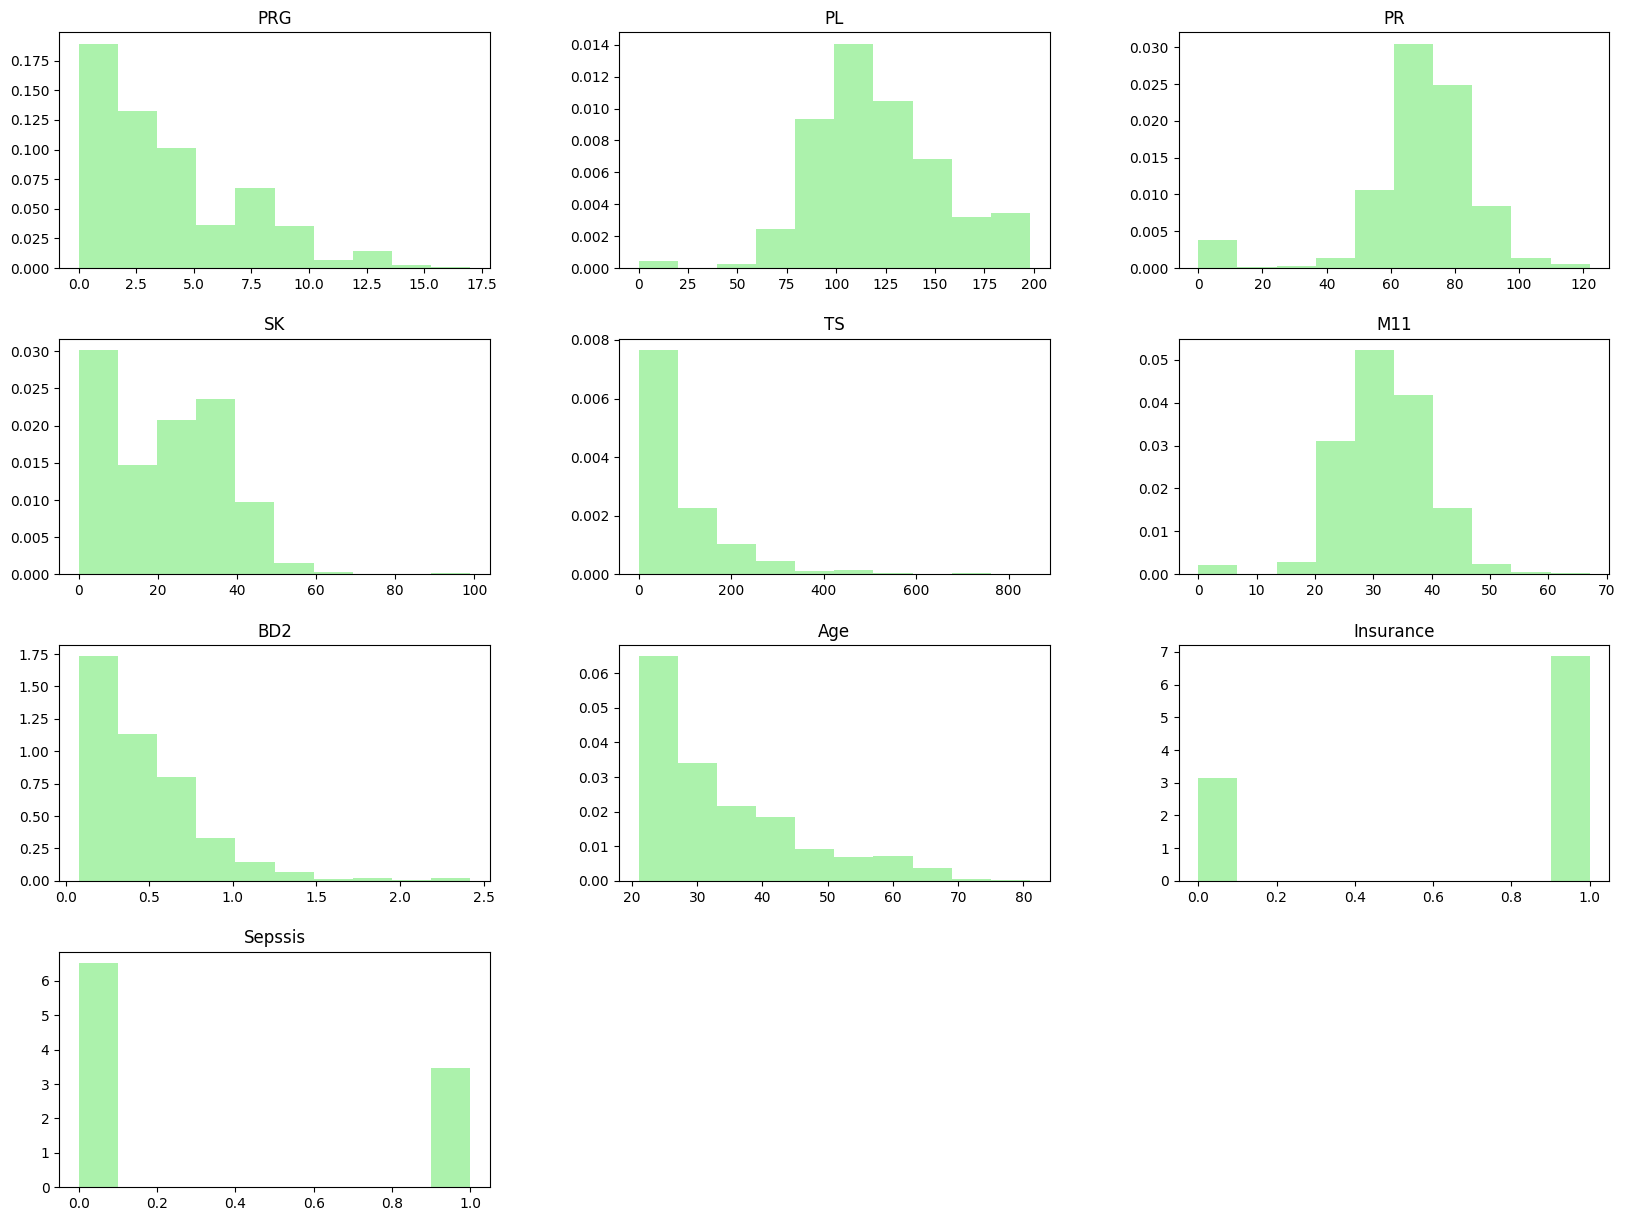

In [21]:

# Distribution of the variables
data.hist(density = True,figsize = (20, 15), facecolor = 'lightgreen', alpha = 0.75,grid = False)

plt.show()


#### OBSERVATION
- The Gender is evenly distributed 
- Over 50% of all contract types are month-on-month basis
- Electronic Check is the most used,covering 30% of all payment methods


In [22]:


labels = ['Sepssis Negative','Sepssis Positive']
values = data.value_counts("Sepssis")

colors = ['mediumturquoise', 'lightgreen']

# pull is given as a fraction of the pie radius
fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[ 0, 0.2])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(title_text='Sepssis Pie Chart')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

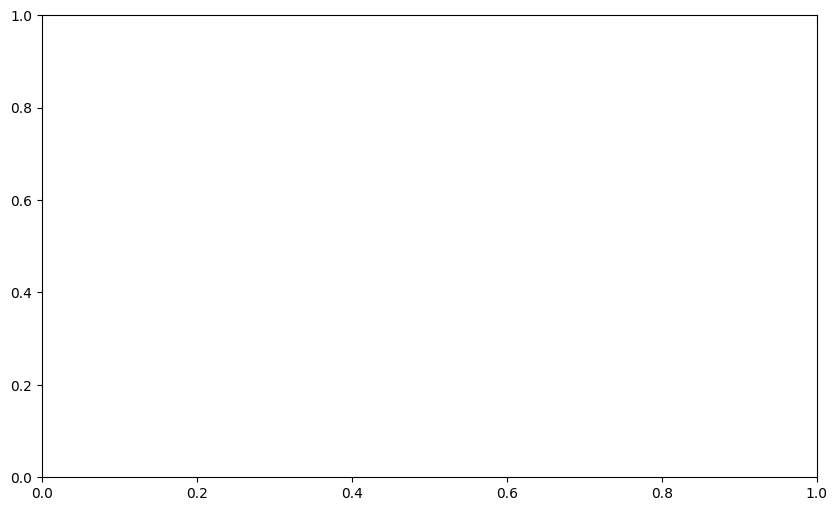

In [23]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Loop through each column in the DataFrame and create a KDE plot on the same graph
for column in data.columns:
    sns.kdeplot(data[column], shade=True, label=column)

# Add legend and labels
plt.legend(title="Patients X'tics")
plt.title('KDE Plots of All Columns')


# Show the plot
plt.show()

In [25]:
# Create an empty figure
fig = go.Figure()

# Loop through each column in the DataFrame and add a KDE plot to the figure
for column in data.columns:
    fig.add_trace(go.Violin(y=data[column], name=column, box_visible=True, meanline_visible=True))

# Update layout for better visualization
fig.update_layout(
    title='KDE Plots of All Columns',
    xaxis_title='Value',
    yaxis_title='Density',
    template='plotly_white'
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'ID',
              'type': 'violin',
              'y': array(['ICU200010', 'ICU200011', 'ICU200012', ..., 'ICU200606', 'ICU200607',
                          'ICU200608'], dtype=object)},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'PRG',
              'type': 'violin',
              'y': array([6, 1, 8, ..., 0, 1, 1])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'PL',
              'type': 'violin',
              'y': array([148,  85, 183, ...,  67,  89, 173])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'PR',
              'type': 'violin',
              'y': array([72, 66, 64, ..., 76, 24, 74])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'SK',
              'type': 'violin',
              'y': array([35, 29,  0, ...,  0, 19,  0])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'TS',
              'type': 'violin',
              'y': array([ 0,  0,  0, ...,  0, 25,  0])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'M11',
              'type': 'violin',
              'y': array([33.6, 26.6, 23.3, ..., 45.3, 27.8, 36.8])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'BD2',
              'type': 'violin',
              'y': array([0.627, 0.351, 0.672, ..., 0.194, 0.559, 0.088])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'Age',
              'type': 'violin',
              'y': array([50, 31, 32, ..., 46, 21, 38])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'Insurance',
              'type': 'violin',
              'y': array([0, 0, 1, ..., 1, 0, 1])},
             {'box': {'visible': True},
              'meanline': {'visible': True},
              'name': 'Sepssis',
              'type': 'violin',
              'y': array([1, 0, 1, ..., 0, 0, 1])}],
    'layout': {'template': '...',
               'title': {'text': 'KDE Plots of All Columns'},
               'xaxis': {'title': {'text': 'Value'}},
               'yaxis': {'title': {'text': 'Density'}}}
})

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

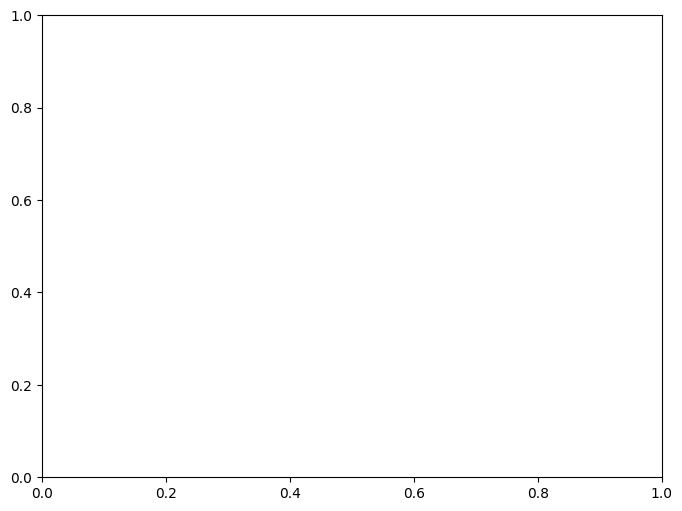

In [26]:
for column in data.columns:
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    sns.kdeplot(data[column], shade=True)
    plt.title(f'KDE plot of {column}')
    #plt.xlabel(f'{column}')
    plt.show()  # Show the plot

### Bivariate Analysis

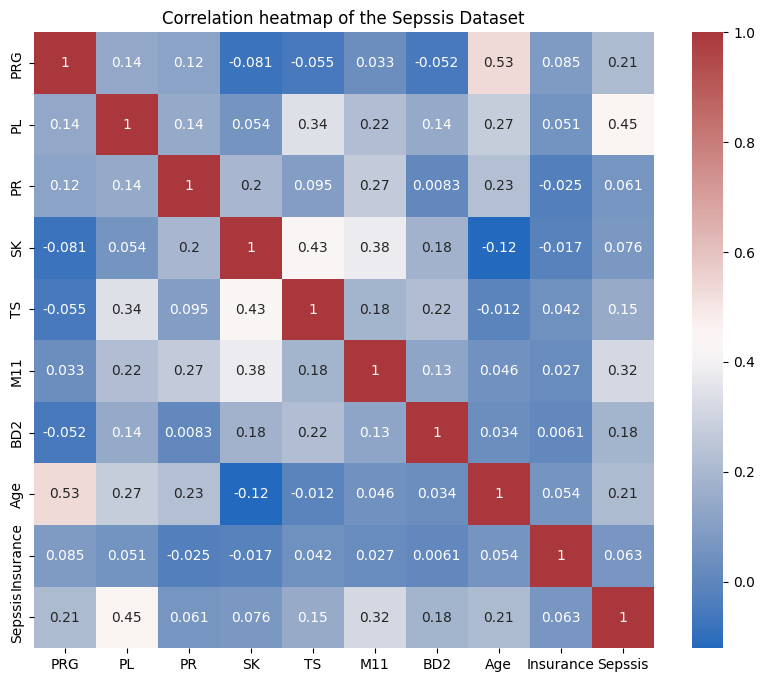

In [27]:

# Summarizing the relationships between the variables with a heatmap of the correlations
correlation_matrix = data.corr(numeric_only = True)
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot = True,cmap = 'vlag')
plt.title("Correlation heatmap of the Sepssis Dataset")
plt.show()

## `Answering the Analytical Questions`


##### `Are older patients more likely to have sepsis?(50 and above)`

In [28]:
fig = px.violin(data, y="Age", color="Sepssis",box = True,points='all',
                #violinmode='overlay', # draw violins on top of each other
                # default violinmode is 'group' as in example above
                hover_data=data.columns)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### OBSERVATION
- More likely to get Sepssis between the ages of 30 and 60.
- Children and teenagers and young adults below 27 are less likely to be diagnosed.

##### `Are older patients with high plasma glucose likely to have sepsis?`


In [29]:
old_and_glucose = data.loc[(data['Age'] > 50) & (data['PRG'] > 5 )]


In [31]:
fig = px.histogram(old_and_glucose, x="Sepssis",  barmode='group', color ='Sepssis',
             height=400,title='Likelihood of older patients with high plasma glucose having sepsis')
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### OBSERVATION
- Still likely to have sepssis with high plasma glucose if you are above 50 years

#### ` Is Obesity with aging a risk factor for sepsis?`


In [32]:
#When BMI is greater than 30, a patient is obese
obese = data.loc[(data['M11'] > 29) ]#& (data['Age'] > 35 )]
fig = px.histogram(obese, x="Sepssis",  barmode='group', color ='Sepssis',
             height=400,title='Likelihood of older patients with high plasma glucose having sepsis')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### OBSERVATION
- An obese patient over 35 years old is likely to be diagnosed of Sepssis

#### `Is there a relation between bloodwork and sepsis?`

In [33]:
# Create 3 dimensional scatter plot 

figure = px.scatter_3d(data,
                 x='PL', y='SK',
                 z='TS', color="Sepssis", 
                 title="Relationship between bloodworks results(mu) and Sepssis")
 
# Update the layout using update_layout 
# function to show the legend
figure.update_layout(showlegend=True)
 
figure.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### OBSERVATION
A lower TS and SK bloodwork results coupled with a higher PL bloodworks result makes a patient highly susceptible to Sepssis.


#### `Are patients with insurance more likely to detect sepsis?`

In [1251]:

insured = data.loc[(data['Insurance'] == 1)]
fig = px.histogram(data, x="Insurance",  barmode='group', color ='Sepssis',
             height=400,title='Likelihood of insured patients with with sepsis as against without')
fig.show()


##### OBSERVATION 
People with insurane are able to detect Sepssis early as compared to non-insurance holders as they find hospitals expensive.

#### `HYPOTHESIS`

In [34]:

#Checking Normality of the data 

def check_normality(data,name):
    test_stat_normality, p_value_normality = stats.shapiro(data)
    print("p value:%.20f" % p_value_normality)
    if p_value_normality < 0.01:
        print(f"Reject null hypothesis >> The data for {name} is not normally distributed")
    else:
        print(f"Fail to reject null hypothesis >> The data for {name} is normally distributed")


In [35]:
#Hypothesis
#patients above 40 with insurance and sepssis
insured_and_above_40 = data.loc[(data['Insurance'] == 1) & (data['Age'] > 40 )]
insured = data.loc[data.Insurance==1]
above_40 = data.loc[data['Age'] > 40] 


#Normality Checks
check_normality(insured_and_above_40.Sepssis,'Insured and above 40')
check_normality(insured.Sepssis,'Insured')
check_normality(above_40.Sepssis,'Above')


p value:0.00000000000000479148
Reject null hypothesis >> The data for Insured and above 40 is not normally distributed
p value:0.00000000000000000000
Reject null hypothesis >> The data for Insured is not normally distributed
p value:0.00000000000000001341
Reject null hypothesis >> The data for Above is not normally distributed


In [36]:

#Using the P-Levene to test the Hypothesis
stat, pvalue_levene = stats.levene(insured_and_above_40.Sepssis, insured.Sepssis,above_40.Sepssis )

print("p value:%.10f" % pvalue_levene)
if pvalue_levene < 0.01:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")


p value:0.0097763629
Reject null hypothesis >> The variances of the samples are different.


In [37]:
#Kruskal Test

stat, p = kruskal(insured_and_above_40.Sepssis, insured.Sepssis,above_40.Sepssis)
print('Statistics=%.3f, p=%.15f' % (stat, p))

if p > 0.01:
 print('All sample distributions are the same (fail to reject H0)')
else:
 print('One or more sample distributions are not equal distributions (reject null Hypothesis)')

Statistics=11.932, p=0.002564985332354
One or more sample distributions are not equal distributions (reject null Hypothesis)


In [38]:
#perform two sample t-test
results= stats.ttest_ind(a=insured.Sepssis, b=above_40.Sepssis) 

print(results.pvalue,results.statistic)

print("p value:%.7f" % results.pvalue)
if results.pvalue < 0.01:
    print(f"Reject null hypothesis >> Since the p_value {results.pvalue} is less than 0.01")
else:
    print(f"Fail to reject null hypothesis >> Since the p_value {results.pvalue} is greater than 0.01")

0.0018696306055741832 -3.1251613469498403
p value:0.0018696
Reject null hypothesis >> Since the p_value 0.0018696306055741832 is less than 0.01


##### Observation 
Reject Null Hypothesis : There is no early detection of Sepssis for patients above 40 with insurance.


### `Data preparation`

- Check outliers of each feature
- Check distribution of dependent feature

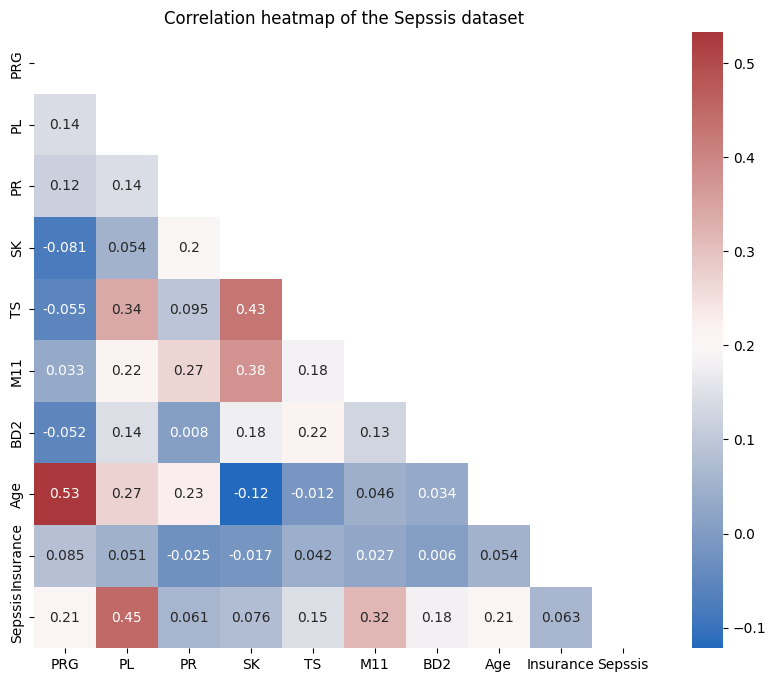

In [39]:
#### Feature Correlation and Selection

# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = data.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the Sepssis dataset")
plt.show()


In [1258]:
# # Create box plots for each column
# for column in data.columns:
#     fig = px.box(data, y=column, title=f'Box Plot of {column}')
#     fig.show()

In [40]:
def replace_outliers_with_limits(df,columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        df[column] = np.where(df[column] < lower_limit, lower_limit, df[column])
        df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
        
        print(f"Column: {column}")
        print(f"Q1 (25th percentile): {Q1}")
        print(f"Q3 (75th percentile): {Q3}")
        print(f"Interquartile Range (IQR): {IQR}")
        print(f"Lower limit: {lower_limit}")
        print(f"Upper limit: {upper_limit}\n")


In [1260]:
data

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,0.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,1.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
594,6.0,123.0,72.0,45.0,230.0,33.6,0.733,34.0,0.0,0.0
595,0.0,188.0,82.0,14.0,185.0,32.0,0.682,22.0,1.0,1.0
596,0.0,67.0,76.0,0.0,0.0,45.3,0.194,46.0,1.0,0.0
597,1.0,89.0,24.0,19.0,25.0,27.8,0.559,21.0,0.0,0.0


In [41]:
# Apply the function to the DataFrame
columns=['PRG','PL','PR','SK','TS','M11','BD2','Age'] #PRG,PL,PR,SK,TS,M11,BD2,Age,
replace_outliers_with_limits(data,columns)



Column: PRG
Q1 (25th percentile): 1.0
Q3 (75th percentile): 6.0
Interquartile Range (IQR): 5.0
Lower limit: -6.5
Upper limit: 13.5

Column: PL
Q1 (25th percentile): 99.0
Q3 (75th percentile): 140.0
Interquartile Range (IQR): 41.0
Lower limit: 37.5
Upper limit: 201.5

Column: PR
Q1 (25th percentile): 64.0
Q3 (75th percentile): 80.0
Interquartile Range (IQR): 16.0
Lower limit: 40.0
Upper limit: 104.0

Column: SK
Q1 (25th percentile): 0.0
Q3 (75th percentile): 32.0
Interquartile Range (IQR): 32.0
Lower limit: -48.0
Upper limit: 80.0

Column: TS
Q1 (25th percentile): 0.0
Q3 (75th percentile): 123.5
Interquartile Range (IQR): 123.5
Lower limit: -185.25
Upper limit: 308.75

Column: M11
Q1 (25th percentile): 27.1
Q3 (75th percentile): 36.55
Interquartile Range (IQR): 9.449999999999996
Lower limit: 12.925000000000008
Upper limit: 50.724999999999994

Column: BD2
Q1 (25th percentile): 0.248
Q3 (75th percentile): 0.647
Interquartile Range (IQR): 0.399
Lower limit: -0.35050000000000003
Upper limit

In [1262]:
# # Create box plots for each column
# for column in data.columns:
#     fig = px.box(data, y=column, title=f'Box Plot of {column}')
#     fig.show()

#### `Distribution of the dependent variable`

##### Dataset classification

- Checking to see if the binary dependent variables are evenly distributed or not 
- With the current levels of disparity between the two classes what stratification method will be best
- Check outliers in the features and resolve them 


In [42]:

# Separate majority and minority classes
diagnosed = data[data.Sepssis== 0]
free = data[data.Sepssis==1]

print((len(diagnosed)/len(data)),(len(free)/len(data)))



0.6527545909849749 0.34724540901502504


##### Observation
- About 65% of the patients are Sepssis which represent the majority group.
- For this dataset, it will be best to use SMOTE to balance the dataset.


#### `Modeling`


In [43]:
data.head(5)
X=data.drop(columns=['Sepssis'],axis=1)
y=data['Sepssis']#.replace({'Yes': 1, 'No': 0})

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 27)

##### `Making pipelines`

In [45]:

scaler = StandardScaler()
normalizer = Normalizer(norm='l2',)
power_trx = PowerTransformer(method="yeo-johnson")
#encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
quantile = QuantileTransformer(output_distribution= 'normal',ignore_implicit_zeros= True,random_state=27)
min_max_scaler = MinMaxScaler()

# putting numeric columns to scaler and categorical to encoder
num_transformer = Pipeline(steps = [
     ('num_imputer', SimpleImputer(strategy = 'median')),
    ('num', scaler)
])
quant_transformer = Pipeline(steps =[
     ('num_imputer', SimpleImputer(strategy = 'median')),
    ('quant', quantile) 
    ])
power_transformer = Pipeline(steps =[
     ('num_imputer', SimpleImputer(strategy = 'median')),
    ('power', power_trx) 
    ])
norm_transformer = Pipeline(steps =[
     ('num_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('norm', normalizer) 
    ])
#naivesbayestheorem,robustscaler,

In [46]:

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers = [('num', num_transformer ,['PRG','PR','TS'])
                   ,('quant', quant_transformer ,['M11','Age'])
                   ,('power', power_transformer ,['PL','SK','TS','BD2'])
                   ,('norm', norm_transformer ,['PRG','PR'])
     
                    ])
#['PRG','PL','PR','SK','TS','M11','BD2','Age']

In [47]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('num', StandardScaler())]),
                                 ['PRG', 'PR', 'TS']),
                                ('quant',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('quant',
                                                  QuantileTransformer(ignore_implicit_zeros=True,
                                                                      output_distribution='normal',
                                                                      random_state=27))]),
                                 ['M11', 'Age']),
                                ('power',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['PL', 'SK', 'TS', 'BD2']),
                                ('norm',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('norm', Normalizer())]),
                                 ['PRG', 'PR'])])

In [48]:

#Calling the models of interest

log_mod =  (LogisticRegression(random_state = 27 ))
svc_mod = SVC(random_state=27,probability= True)

#catboost_mod = (CatBoostClassifier(random_state=27, verbose = False))
xgboost_mod = XGBClassifier(random_state=27)
 


In [49]:

# Create a dictionary of the model pipelines
all_models_pipelines = {"Logistic_Regressor": (LogisticRegression(random_state = 27 )),
              "SVM": SVC(random_state = 27,probability = True),
              #"CatBoost": (CatBoostClassifier(random_state=27, verbose = False)),
              "Xgboost":XGBClassifier(random_state=27)
              }
    


In [50]:

# Create a function to model and return comparative model evaluation scores,perform the SMOTE on each model pipeline,to calculate and compare accuracy

def evaluate_models(model_pipelines = all_models_pipelines, X_test = X_test, y_test = y_test):


    # Dictionary for trained models
    trained_models = dict()

    # Create a dataframe matrix to all pipelines
    all_confusion_matrix = []
    
    
    # List to receive scores
    performances = []
    for name, model_pipeline in model_pipelines.items():
        final_pipeline = imbpipeline(steps=[("preprocessor", preprocessor), 
                                   ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')),
                                   ("feature_selection",SelectKBest(mutual_info_classif, k = 'all')),
                           ("model", model_pipeline)])
    


        
        final_pipeline.fit(X_train,  y_train)
       

        # Predict and calculate performance scores
        y_pred = final_pipeline.predict(X_test)
        performances.append([name,
                             accuracy_score(y_test, y_pred),  # accuracy
                             precision_score(y_test, y_pred, average="weighted"),  # precisions
                             recall_score(y_test, y_pred,average="weighted"),  # recall
                             f1_score(y_test, y_pred, average="weighted")
                             ])

        # Print classification report
        model_pipeline_report = classification_report(y_test, y_pred)
        print("This is the classification report of the",name, "model", "\n", model_pipeline_report, "\n")

        # Defining the Confusion Matrix
        model_pipeline_conf_mat = confusion_matrix(y_test, y_pred)
        model_pipeline_conf_mat = pd.DataFrame(model_pipeline_conf_mat).reset_index(drop = True)
        print(f"Below is the confusion matrix for the {name} model")

        # Visualizing the Confusion Matrix
        f, ax = plt.subplots()
        sns.heatmap(model_pipeline_conf_mat, annot = True, linewidth = 1.0,fmt = ".0f", cmap = "RdPu", ax=ax)
        plt.xlabel = ("Prediction")
        plt.ylabel = ("Actual")
        plt.show()

        # Store trained model
        trained_model_name = "trained_" + str(name).lower()
        trained_models[trained_model_name] = final_pipeline
        
        print("\n", "-----   -----"*6, "\n",  "-----   -----"*6)
    
    # Compile accuracy
    df_compare = pd.DataFrame(performances, columns = ["model", "accuracy", "precision", "recall", "f1_score"])
    df_compare.set_index("model", inplace = True)
    df_compare.sort_values(by = ["f1_score", "accuracy"], ascending = False, inplace=True)
    return df_compare, trained_models


This is the classification report of the Logistic_Regressor model 
               precision    recall  f1-score   support

           0       0.87      0.74      0.80       282
           1       0.59      0.77      0.67       138

    accuracy                           0.75       420
   macro avg       0.73      0.75      0.73       420
weighted avg       0.78      0.75      0.75       420
 

Below is the confusion matrix for the Logistic_Regressor model


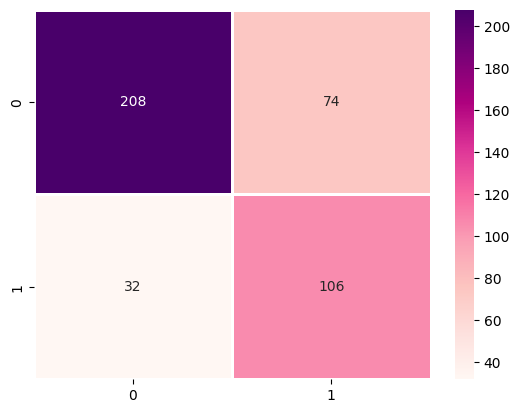


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----
This is the classification report of the SVM model 
               precision    recall  f1-score   support

           0       0.80      0.67      0.73       282
           1       0.49      0.67      0.57       138

    accuracy                           0.67       420
   macro avg       0.65      0.67      0.65       420
weighted avg       0.70      0.67      0.68       420
 

Below is the confusion matrix for the SVM model


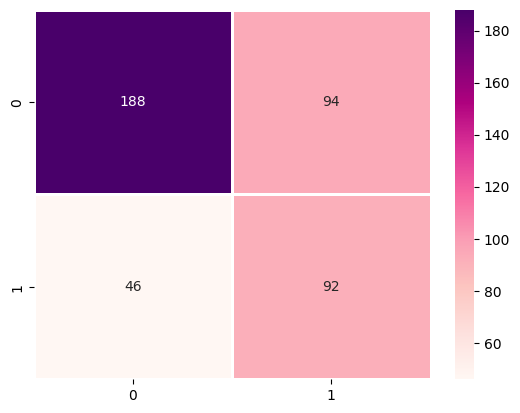


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----
This is the classification report of the Xgboost model 
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       282
           1       0.57      0.66      0.61       138

    accuracy                           0.73       420
   macro avg       0.70      0.71      0.70       420
weighted avg       0.74      0.73      0.73       420
 

Below is the confusion matrix for the Xgboost model


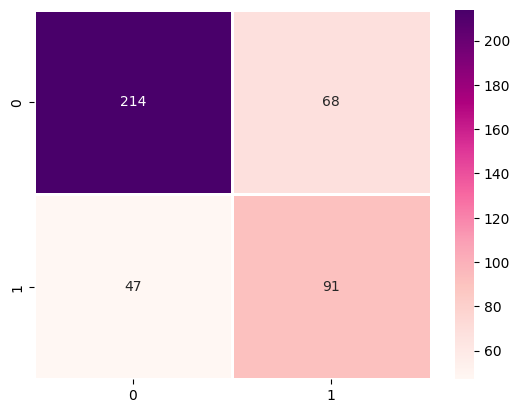


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----


,accuracy,precision,recall,f1_score
model,,,,
Logistic_Regressor,0.747619,0.775397,0.747619,0.754132
Xgboost,0.726190,0.738570,0.726190,0.730576
SVM,0.666667,0.701958,0.666667,0.675854


In [51]:

# Run the function to train models and return performances
all_models_eval, trained_models = evaluate_models()
all_models_eval


#### `Visualizing Evaluation Using ROC - AUC`

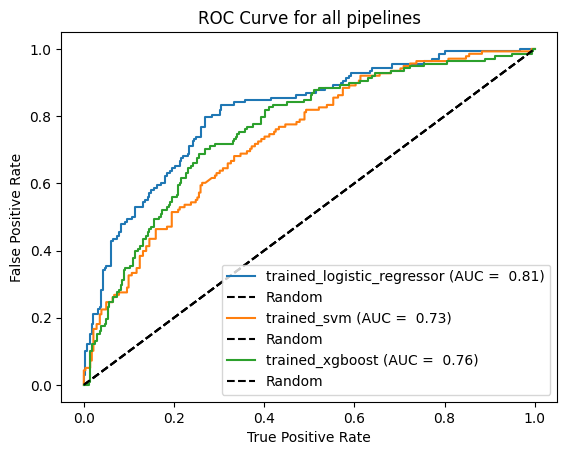

In [52]:

from sklearn.metrics import roc_curve,auc

all_roc_data = {}
fig, ax = plt.subplots()

for name,model in trained_models.items():
    y_score = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    roc_auc = auc(fpr,tpr)
    roc_data_df = pd.DataFrame({'False Positive Rate' : fpr , 'True Positve Rate' : tpr , 'Threshold' : thresholds})
    all_roc_data[name] = roc_data_df

    ax.plot(fpr,tpr, label = f'{name} (AUC = {roc_auc: .2f})')

    ax.plot([0,1],[0,1], linestyle='--', color='k', label='Random')
    ax.set_ylabel('False Positive Rate')
    ax.set_xlabel('True Positive Rate')
    ax.set_title('ROC Curve for all pipelines')

plt.legend()
plt.show()



In [53]:


lr_roc_data = all_roc_data["trained_logistic_regressor"]
svm_roc_data = all_roc_data["trained_svm"]
#catboost_roc_data = all_roc_data["trained_catboost"]
xgboost_roc_data = all_roc_data["trained_xgboost"]



KeyError: 'trained_catboost'

##### `Business Impact Assessment`

- The true positive rate is sensitive but there is a need to raise its sensitivity higher for production
- The acceptable threshold to meet the criteria is 0.4812 for the Logistic Regression model
- The acceptable threshold to meet the criteria is 0.3703 for the SVM model
- The acceptable threshold to meet the criteria is 0.2398 for the Cat Boost model
- The acceptable threshold to meet the criteria is 0.2189 for the Xgboost model


#### `Hyperparameter Tuning`


In [54]:
## XGBoost Classifier
xgb_clf = imbpipeline(steps=[("preprocessor", preprocessor), ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')),
                          ("model", XGBClassifier(random_state=27))])


# Defining the values for the RandomizedSearchCV
param_grid_xgboost = {"model__learning_rate": [0.1, 0.3, 0.5, 0.7, 1.0],
               "model__max_depth": [5, 10, 15, 20, 25, 30, 35],
               "model__booster": ["gbtree", "gblinear", "dart"],
               "model__n_estimators":  list(range(2, 11, 2))
              }


In [55]:

# Running the RandomizedSearch Cross-Validation with the above set of Parameters
grid_search_model = GridSearchCV(estimator = xgb_clf, param_grid = param_grid_xgboost, n_jobs=-1, scoring = "accuracy")


# Fitting the model to the training data
grid_search_model.fit(X_train,y_train)

print("Best parameter (CV score=%0.5f):" % grid_search_model.best_score_)
print(f"The best parameters for the GSCV XGB are: {grid_search_model.best_params_}")


In [1277]:

# Looking at the best combination of hyperparameters for the model
best_gs_params = grid_search_model.best_params_
print("The best combination of hyperparameters for the model will be:")
for param_name in sorted(best_gs_params.keys()):
    print(f"{param_name} : {best_gs_params[param_name]}")


The best combination of hyperparameters for the model will be:
model__booster : gblinear
model__learning_rate : 0.1
model__max_depth : 5
model__n_estimators : 6


In [1278]:

# Defining the best version of the model with the best parameters
best_gs_model = imbpipeline(steps=[("preprocessor", preprocessor), ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')),
                          ("model",XGBClassifier(random_state=27,
                              booster="gblinear",
                              learning_rate=0.5,
                              max_depth = 5,
                              n_estimators=6
                              ))])


[0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1
 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1
 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0
 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0
 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0
 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0
 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0
 0 0 0 1 0 0 1 1 0 1 1 1 0]
              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80       282
         1.0       0.59      0.77     

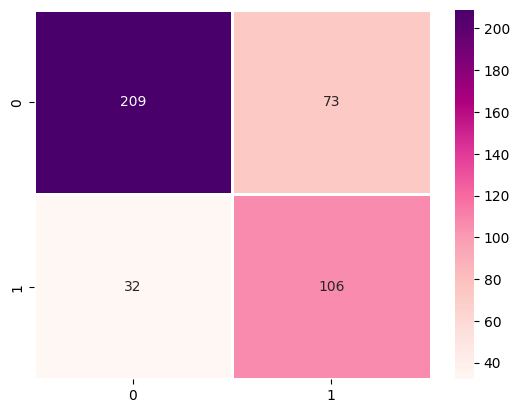

In [1279]:

# Fit the model to the training data
best_gs_model.fit(X_train, y_train)

# Predict on the test data
best_gs_pred = best_gs_model.predict(X_test)

print(best_gs_pred)

# Confusion Matrix
best_gs_conf_mat = (pd.DataFrame(confusion_matrix(y_test, best_gs_pred)).reset_index(drop=True))

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_gs_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)

model_pipeline_report = classification_report(y_test, best_gs_pred)
print(model_pipeline_report)


In [1280]:

logistic_model = LogisticRegression(random_state=27)
logistic_pipeline = imbpipeline(steps=[("preprocessor", preprocessor), ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')), ("model", logistic_model)])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
        'model__penalty': ['l2'],
    'model__solver' : ['lbfgs', 'liblinear', 'newton-cg'],
    'model__max_iter' : [500,700,1000]
}

# Create the RandomizedSearchCV object
clf = GridSearchCV(logistic_pipeline, param_grid=param_distributions, scoring = 'accuracy',error_score='raise')

# Fit the RandomizedSearchCV on your training data
search_model = clf.fit(X_train, y_train)

print("Best parameter (CV score=%0.5f):" % search_model.best_score_)
print(f"The best parameters for the GSCV XGB are: {search_model.best_params_}")



Best parameter (CV score=0.72048):
The best parameters for the GSCV XGB are: {'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


[0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.

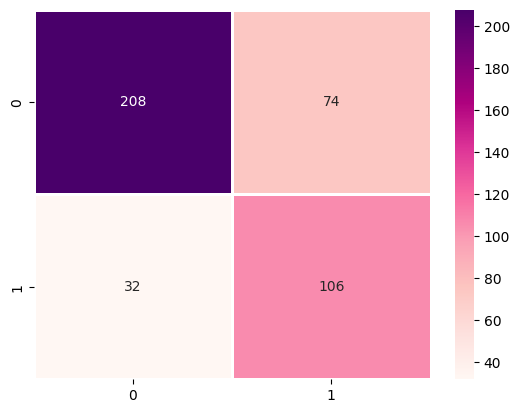

In [1281]:

# Predict on the test data
search_pred = search_model.predict(X_test)

# # Get the best hyperparameters
# best_params = search.best_params_

# print(best_params)
# Defining the best version of the model with the best parameters
best_search_model = imbpipeline(steps=[("preprocessor", preprocessor), ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')), 
                          ("model",LogisticRegression(random_state=27,
                              max_iter=700,
                              penalty='l2',
                              solver = 'lbfgs',
                              verbose=0
                              ))])

# Fit the model to the training data
best_search_model.fit(X_train, y_train)

# Predict on the test data
best_search_pred = best_search_model.predict(X_test)

print(best_search_pred)

# Confusion Matrix
best_gs_conf_mat = (pd.DataFrame(confusion_matrix(y_test, best_search_pred)).reset_index(drop=True))

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_gs_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)

model_pipeline_report = classification_report(y_test, best_search_pred)
print(model_pipeline_report)

print(f1_score(y_test, best_search_pred, average="weighted"))


In [1282]:

cat_model = (CatBoostClassifier(random_state=27))
cat_pipeline = imbpipeline(steps=[("preprocessor", preprocessor), ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')), ("model", cat_model)])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    #'model__C': uniform(scale=4),
    'model__depth': [6],                   # Depth of the trees
    'model__learning_rate': [0.1,1],          # Learning rate of the model
    'model__l2_leaf_reg': [3],              # L2 regularization term on weights
    'model__rsm': [0.2,0.8],                   # Random Selection Rate (regularization by introducing randomness)
    'model__iterations': [500,800],            # Number of boosting iterations
    'model__loss_function': ['MultiClass'], # Loss function for multi-class classification
    'model__eval_metric': ['Accuracy'],    # Evaluation metric

}

# Create the RandomizedSearchCV object
cat_clf = GridSearchCV(cat_pipeline, param_grid=param_distributions, scoring = 'accuracy',error_score='raise')

# Fit the RandomizedSearchCV on your training data
cat_gs_model = cat_clf.fit(X_train, y_train)

print("Best parameter (CV score=%0.5f):" % cat_gs_model.best_score_)
print(f"The best parameters for the GSCV XGB are: {cat_gs_model.best_params_}")



0:	learn: 0.7758621	total: 2.21ms	remaining: 1.1s
1:	learn: 0.7816092	total: 4.48ms	remaining: 1.11s
2:	learn: 0.8045977	total: 7.15ms	remaining: 1.18s
3:	learn: 0.8275862	total: 8.52ms	remaining: 1.06s
4:	learn: 0.8448276	total: 9.76ms	remaining: 966ms
5:	learn: 0.8390805	total: 11.6ms	remaining: 956ms
6:	learn: 0.8218391	total: 12.2ms	remaining: 859ms
7:	learn: 0.8275862	total: 14ms	remaining: 863ms
8:	learn: 0.8275862	total: 16.3ms	remaining: 887ms
9:	learn: 0.8390805	total: 17.2ms	remaining: 844ms
10:	learn: 0.8505747	total: 17.9ms	remaining: 797ms
11:	learn: 0.8275862	total: 18.5ms	remaining: 754ms
12:	learn: 0.8448276	total: 20.5ms	remaining: 768ms
13:	learn: 0.8448276	total: 22.7ms	remaining: 788ms
14:	learn: 0.8448276	total: 23.3ms	remaining: 753ms
15:	learn: 0.8448276	total: 23.5ms	remaining: 710ms
16:	learn: 0.8448276	total: 23.6ms	remaining: 672ms
17:	learn: 0.8333333	total: 25.3ms	remaining: 677ms
18:	learn: 0.8563218	total: 26.8ms	remaining: 678ms
19:	learn: 0.8505747	tota

In [1283]:

# Predict on the test data
cat_gs__pred =cat_gs_model.predict(X_test)
#print(cat_gs__pred)

In [1284]:

# # Get the best hyperparameters
# best_params = search.best_params_

# print(best_params)
# Defining the best version of the model with the best parameters
best_gs_catboost_model = imbpipeline(steps=[("preprocessor", preprocessor), ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')),
                          ("model",CatBoostClassifier(random_state=27,
                              iterations=8000,
                              depth=6,
                              eval_metric = 'Accuracy',
                              l2_leaf_reg=3,
                              learning_rate=0.1,
                              rsm = 0.3,
                              loss_function = 'MultiClass',
                              

                              ))])

# Fit the model to the training data
best_gs_catboost_model.fit(X_train, y_train)

# Predict on the test data
best_catboost_pred = best_gs_catboost_model.predict(X_test)

#print(best_catboost_pred)



0:	learn: 0.7614679	total: 3.44ms	remaining: 27.5s
1:	learn: 0.7889908	total: 6.34ms	remaining: 25.4s
2:	learn: 0.7981651	total: 8.86ms	remaining: 23.6s
3:	learn: 0.7935780	total: 11ms	remaining: 22s
4:	learn: 0.8073394	total: 14.3ms	remaining: 22.9s
5:	learn: 0.7981651	total: 16.4ms	remaining: 21.9s
6:	learn: 0.7889908	total: 19.3ms	remaining: 22s
7:	learn: 0.8119266	total: 21.2ms	remaining: 21.2s
8:	learn: 0.8211009	total: 23.3ms	remaining: 20.7s
9:	learn: 0.8119266	total: 25.6ms	remaining: 20.4s
10:	learn: 0.8211009	total: 28.4ms	remaining: 20.6s
11:	learn: 0.8027523	total: 29.7ms	remaining: 19.8s
12:	learn: 0.8027523	total: 30.7ms	remaining: 18.9s
13:	learn: 0.8165138	total: 33.3ms	remaining: 19s
14:	learn: 0.8027523	total: 35.7ms	remaining: 19s
15:	learn: 0.8119266	total: 37.8ms	remaining: 18.9s
16:	learn: 0.8165138	total: 39.7ms	remaining: 18.6s
17:	learn: 0.8165138	total: 44.1ms	remaining: 19.5s
18:	learn: 0.8348624	total: 46ms	remaining: 19.3s
19:	learn: 0.8302752	total: 48.4ms

0.7008528958717041


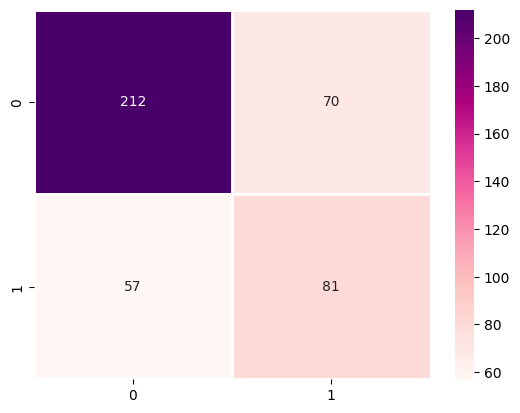

In [1285]:

# Confusion Matrix
best_search_conf_mat = (pd.DataFrame(confusion_matrix(y_test, best_catboost_pred)).reset_index(drop=True))

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_search_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)

# model_pipeline_report = classification_report(y_test, best_catboost_pred)
# print(model_pipeline_report)

print(f1_score(y_test, best_catboost_pred, average="weighted"))


In [1286]:

svc_model = SVC(random_state=27)
svc_pipeline = imbpipeline(steps=[("preprocessor", preprocessor), ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')), ("model", svc_model)])

# Define the parameter distributions for GridSearchCV
param_distributions = {
    
    'model__break_ties': [True],                   
    'model__kernel': ['linear','rbf','poly'],         
    'model__max_iter': [-1],              
    'model__coef0': [0.0,0.2],                
    'model__probability': [True ],           
    'model__shrinking': [True,False], 
    'model__verbose': [True],    
    'model__tol' : [0.0001,0.1]
}

# Create the GridSearchCV object
svc_clf = GridSearchCV(svc_pipeline, param_grid=param_distributions, scoring = 'accuracy',error_score='raise')

# Fit the GridSearchCV on your training data
svc_gs_model = svc_clf.fit(X_train, y_train)

print("Best parameter (CV score=%0.5f):" % svc_gs_model.best_score_)
print(f"\nThe best parameters for the GSCV XGB are: {svc_gs_model.best_params_}")



[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Best parameter (CV score=0.71524

In [1287]:

# Defining the best version of the model with the best parameters
best_gs_svc_model = imbpipeline(steps=[("preprocessor", preprocessor), ('smote-sampler',SMOTE(random_state = 27,sampling_strategy='auto')),
                          ("model",SVC(random_state=27,
                              break_ties=True,
                              coef0 = 0.0,
                              kernel = 'poly',
                              probability = True,
                              max_iter =-1,
                              shrinking = True,  
                              tol = 0.0001,
                              verbose=True                                                    
                              ))])

# Fit the model to the training data
best_gs_svc_model.fit(X_train, y_train)

# Predict on the test data
best_svc_pred = best_gs_svc_model.predict(X_test)
#best_svc_pred = best_gs_svc_model.predict_proba(X_test)
print(best_svc_pred)


[LibSVM][0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 

              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       282
         1.0       0.53      0.56      0.55       138

    accuracy                           0.70       420
   macro avg       0.66      0.66      0.66       420
weighted avg       0.70      0.70      0.70       420

0.6968417382967829


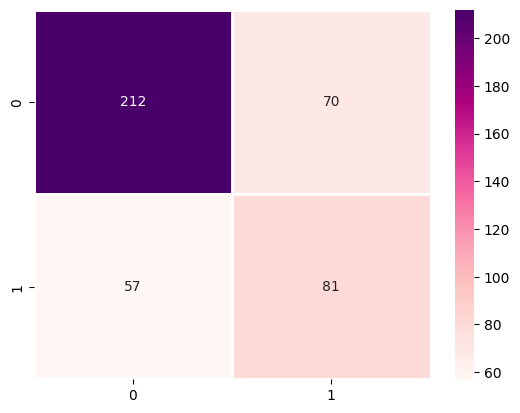

In [1288]:

# Confusion Matrix
best_svc_conf_mat = (pd.DataFrame(confusion_matrix(y_test, best_svc_pred)).reset_index(drop=True))

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_search_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)

model_pipeline_report = classification_report(y_test, best_svc_pred)
print(model_pipeline_report)

print(f1_score(y_test, best_svc_pred, average="weighted"))


#### `Testing one of the models with the test data set`


test_data = pd.read_csv('data\Paitients_Files_Test.csv')
test_data.drop(columns=['ID'],inplace = True)

best_svc_pred = best_gs_svc_model.predict(test_data)

print(best_svc_pred)


#### `Persit the model`

for name, model_pipeline in all_models_pipelines.items():
    joblib.dump(model_pipeline,f'models\{name}.joblib')

In [1289]:
joblib.dump(best_gs_model,'./models/best_gs_model.joblib')



['./models/best_gs_model.joblib']